# Taller Simulación de ML

#Librerias y configuraciones previas


In [57]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import math

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import sklearn.metrics as metrics
from sklearn.impute import MissingIndicator

from sklearn.preprocessing import OneHotEncoder 
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.neighbors import LocalOutlierFactor

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

plt.rcParams['image.cmap'] = "bwr"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
import os
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Funciones

In [4]:
def plot_multiples_graficas(df, cols, num_cols, num_rows, tipo, targetVar, figsize=(16,8)):
    
    plt.rcParams['figure.figsize'] = figsize
    fig, axs = plt.subplots(num_rows, num_cols)
    
    for ind, col in enumerate(cols):
        i = math.floor(ind/num_cols)
        j = ind - i*num_cols
        
        if num_rows == 1:
            if num_cols == 1:
                if tipo == 'c': 
                    sns.countplot(x=df[col], ax=axs, dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs)
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs)
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[j])
        else:
            if num_cols == 1:
                if tipo == 'c':
                    sns.countplot(x=d[col], ax=axs[i], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i])
            else:
                if tipo == 'c':
                    sns.countplot(x=df[col], ax=axs[i, j], dodge = False)
                if tipo == 'b':
                    sns.boxplot(x=df[col], y=df[targetVar], ax=axs[i, j])
                if tipo == 's':
                    sns.scatterplot(x=df[col], y=df[targetVar], ax=axs[i, j])

In [5]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [29]:
from scipy.stats import spearmanr
class Spearman_Correlation:
  def corr_spearman(self, Features):
        spearman = []
        valor_p = []
        Data_n = Features.values
        Data_n = np.asarray(Data_n)

        for _, n in enumerate(np.arange(0, Data_n.shape[1])):
            for _, m in enumerate(np.arange(0, Data_n.shape[1])):
                s_valor, p_valor = spearmanr(Data_n[:, n], Data_n[:, m])
                spearman.append(s_valor)
                valor_p.append(p_valor)

        spearman = np.asarray(spearman)
        spearman_r = spearman.reshape(Data_n.shape[1], Data_n.shape[1])
        valor_p = np.asarray(valor_p)
        p_value = valor_p.reshape(Data_n.shape[1], Data_n.shape[1])
        spearman_r, p_value = pd.DataFrame(
            spearman_r, index=Features.columns, columns=Features.columns
        ), pd.DataFrame(p_value, index=Features.columns, columns=Features.columns)
        return spearman_r, p_value

  def correlation_analysis(self, df_news_noscale):
        spearman_r, p_value_spearman = self.corr_spearman(df_news_noscale)
        columns = p_value_spearman.columns

        traverse = {}
        for row_index in range(p_value_spearman.shape[0]):
            traverse[row_index] = {}
            for column_index in range(p_value_spearman.shape[0]):
                traverse[row_index][column_index] = True

        for row_index in range(p_value_spearman.shape[0]):
            for column_index in range(p_value_spearman.shape[0]):
                if (
                    p_value_spearman[columns[column_index]][row_index] < 0.05
                    and row_index != column_index
                    and (
                        spearman_r[columns[column_index]][row_index] > 0.8
                        or spearman_r[columns[column_index]][row_index] < -0.8
                    )
                    and traverse[row_index][column_index] == True
                    and traverse[column_index][row_index] == True
                ):
                    print(
                        "({}, {}) (pvalue={:.3f}, corr={:.3f})".format(
                            columns[row_index],
                            columns[column_index],
                            p_value_spearman[columns[column_index]][row_index],
                            spearman_r[columns[column_index]][row_index],
                        )
                    )
                    traverse[row_index][column_index] = False

In [36]:
def build_model(X2,Y2):
    X2 = sm.add_constant(X2)
    lm = sm.OLS(Y2,X2).fit()
    print(lm.summary())
    return X2

In [55]:
def checkVIF(X2):
    vif = pd.DataFrame()
    vif['Features'] = X2.columns
    vif['VIF'] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending = False)
    return(vif)

# 1 - Cancelación tarjetas de crédito - Regresión Logística

Este dataset contiene la información de 10.000 clientes de un banco, lo que se requiere es tener un modelo para predecir quien va a cancelar la tarjeta de crédito, lo que permita que se aborde al cliente proactivamente para conservarlo.

##Carga del dataset

Procedemos a realizar la carga del dataset directamente desde Kaggle:

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/' + input('Input the directory with your Kaggle json file: ')
!kaggle datasets download -d sakshigoyal7/credit-card-customers
!unzip \*.zip && rm *.zip

Input the directory with your Kaggle json file: Colab Notebooks
  0% 0.00/379k [00:00<?, ?B/s]
100% 379k/379k [00:00<00:00, 64.4MB/s]
Archive:  credit-card-customers.zip
  inflating: BankChurners.csv        


In [ ]:
data_bank=pd.read_csv('/content/BankChurners.csv')

In [ ]:
data_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

##Limpieza de datos y preparación

El dataset tiene dos columnas al final sobre clasificación de Bayes, por lo cual no las consideramos para el análisis. Así mismo, prescindimos de la característica Número de Cliente (CLIENTNUM), dado que es una identificación única y no aporta a nuestro experimento:

In [ ]:
data_bank.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1'], axis='columns', inplace=True)
data_bank.drop(['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis='columns', inplace=True)
data_bank.drop(['CLIENTNUM'], axis='columns', inplace=True)

In [ ]:
data_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int64  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int64  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int64  
 9   Total_Relationship_Count  10127 non-null  int64  
 10  Months_Inactive_12_mon    10127 non-null  int64  
 11  Contacts_Count_12_mon     10127 non-null  int64  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int64  
 14  Avg_Op

In [ ]:
data_bank.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Procedemos a validar si existen registros duplicados:

In [ ]:
data_bank.loc[data_bank.duplicated()]

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio


Una vez eliminadas las características no relevantes, vamos a separar las categóricas y continuas para gestionarlas por separado:

In [ ]:
categorical_columns=data_bank.select_dtypes(include = ["object"]).columns.tolist()
continuous_columns=data_bank.select_dtypes(include = ["int64", "float64"]).columns.tolist()
categorical_data = data_bank[categorical_columns]
continuous_data = data_bank[continuous_columns]

Procedemos a validar los datos nulos, los cuales en este caso están como *Unknown* y los pasamos a *NAN* para poder tratarlos:

In [ ]:
for column in categorical_columns:
  values = list(data_bank[column].value_counts().index)
  print("Valores de la columna {columna} : {valores}".format(columna=column, valores=', '.join(values)))

Valores de la columna Attrition_Flag : Existing Customer, Attrited Customer
Valores de la columna Gender : F, M
Valores de la columna Education_Level : Graduate, High School, Unknown, Uneducated, College, Post-Graduate, Doctorate
Valores de la columna Marital_Status : Married, Single, Unknown, Divorced
Valores de la columna Income_Category : Less than $40K, $40K - $60K, $80K - $120K, $60K - $80K, Unknown, $120K +
Valores de la columna Card_Category : Blue, Silver, Gold, Platinum


In [ ]:
data_bank.replace('Unknown',np.nan, inplace=True)

In [ ]:
for col in data_bank.columns:
    print (col, np.sum(pd.isnull(data_bank[col])))

Attrition_Flag 0
Customer_Age 0
Gender 0
Dependent_count 0
Education_Level 1519
Marital_Status 749
Income_Category 1112
Card_Category 0
Months_on_book 0
Total_Relationship_Count 0
Months_Inactive_12_mon 0
Contacts_Count_12_mon 0
Credit_Limit 0
Total_Revolving_Bal 0
Avg_Open_To_Buy 0
Total_Amt_Chng_Q4_Q1 0
Total_Trans_Amt 0
Total_Trans_Ct 0
Total_Ct_Chng_Q4_Q1 0
Avg_Utilization_Ratio 0


Se visualizan que las características con datos nulos son: 

*   Education_Level con 1.519 registros
*   Income_Category con 1.112 registros
*   Marital_Status con 749 registros



 

Ahora, antes de aplicar la imputación de los datos nulos, vamos a convertir los datos categóricos a numéricos a través de la creación de variables dummy y en el caso de la variable de salida, asignando 1 a los clientes existentes y 0 a los que ya no son clientes:

In [ ]:
data_bank["Attrition_Flag"].replace('Existing Customer', "Act",inplace=True)
data_bank["Attrition_Flag"].replace('Attrited Customer', "Canc",inplace=True)

In [ ]:
cat_columns = ['Gender','Education_Level','Marital_Status','Income_Category','Card_Category']
cat_data_sin_y = data_bank[cat_columns]

In [ ]:
data_dummy_encoding = pd.get_dummies(cat_data_sin_y, drop_first = True)
print(data_dummy_encoding.info())
data_dummy_encoding.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   Gender_M                        10127 non-null  uint8
 1   Education_Level_Doctorate       10127 non-null  uint8
 2   Education_Level_Graduate        10127 non-null  uint8
 3   Education_Level_High School     10127 non-null  uint8
 4   Education_Level_Post-Graduate   10127 non-null  uint8
 5   Education_Level_Uneducated      10127 non-null  uint8
 6   Marital_Status_Married          10127 non-null  uint8
 7   Marital_Status_Single           10127 non-null  uint8
 8   Income_Category_$40K - $60K     10127 non-null  uint8
 9   Income_Category_$60K - $80K     10127 non-null  uint8
 10  Income_Category_$80K - $120K    10127 non-null  uint8
 11  Income_Category_Less than $40K  10127 non-null  uint8
 12  Card_Category_Gold              10127 non-null  uint8
 13  C

,Gender_M,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Married,Marital_Status_Single,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0
1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0
2,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0


Realizamos la imputación por el método de la media:

In [ ]:
imp = SimpleImputer(missing_values = np.nan, strategy= 'mean')
imp.fit(data_dummy_encoding)
data_bank_imp_media = imp.transform(data_dummy_encoding)
nombres = data_dummy_encoding.columns
data_bank_imp_media = pd.DataFrame(data_bank_imp_media, columns = nombres)
display(data_bank_imp_media)

,Gender_M,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Married,Marital_Status_Single,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10122,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10123,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
10124,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
10125,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Revalidamos si luego de la imputación nos quedaron datos nulos o no:

In [ ]:
Indicador = MissingIndicator(missing_values = np.nan)
Indicador.fit(data_bank_imp_media)
Datos_Indicador = Indicador.transform(data_bank_imp_media)
display(Datos_Indicador)
print("Características donde hay datos faltantes: ", Indicador.features_)

array([], shape=(10127, 0), dtype=bool)

Características donde hay datos faltantes:  []


Procedemos a unir los datos categóricos y los datos continuos:

In [ ]:
data_bank_processed = pd.concat([data_bank_imp_media, continuous_data], axis = 1)
data_bank_processed = data_bank_processed.astype(float)
y = data_bank["Attrition_Flag"]

In [ ]:
data_bank_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender_M                        10127 non-null  float64
 1   Education_Level_Doctorate       10127 non-null  float64
 2   Education_Level_Graduate        10127 non-null  float64
 3   Education_Level_High School     10127 non-null  float64
 4   Education_Level_Post-Graduate   10127 non-null  float64
 5   Education_Level_Uneducated      10127 non-null  float64
 6   Marital_Status_Married          10127 non-null  float64
 7   Marital_Status_Single           10127 non-null  float64
 8   Income_Category_$40K - $60K     10127 non-null  float64
 9   Income_Category_$60K - $80K     10127 non-null  float64
 10  Income_Category_$80K - $120K    10127 non-null  float64
 11  Income_Category_Less than $40K  10127 non-null  float64
 12  Card_Category_Gold              

##Visualización de datos

In [ ]:
data_bank.groupby('Attrition_Flag').Attrition_Flag.count().sort_values(ascending=False)

Attrition_Flag
Act     8500
Canc    1627
Name: Attrition_Flag, dtype: int64

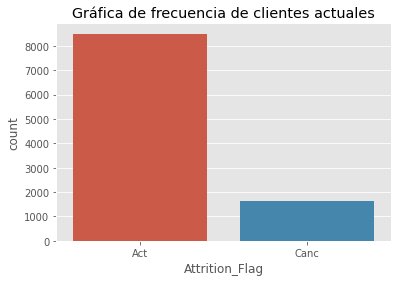

In [ ]:
plt.figure(figsize=(6,4))

plt.title('Gráfica de frecuencia de clientes actuales')
sns.countplot(x=data_bank['Attrition_Flag'])

plt.show()

En la gráfica anterior, se visualiza que los datos se encuentran desproporcionadamente desbalanceados. Primero realizaremos el modelo sin balancear estos datos y posterior los balancearemos para comparar que nos arroja.

Vamos a validar como se comportan nuestras demás variables categóricas:

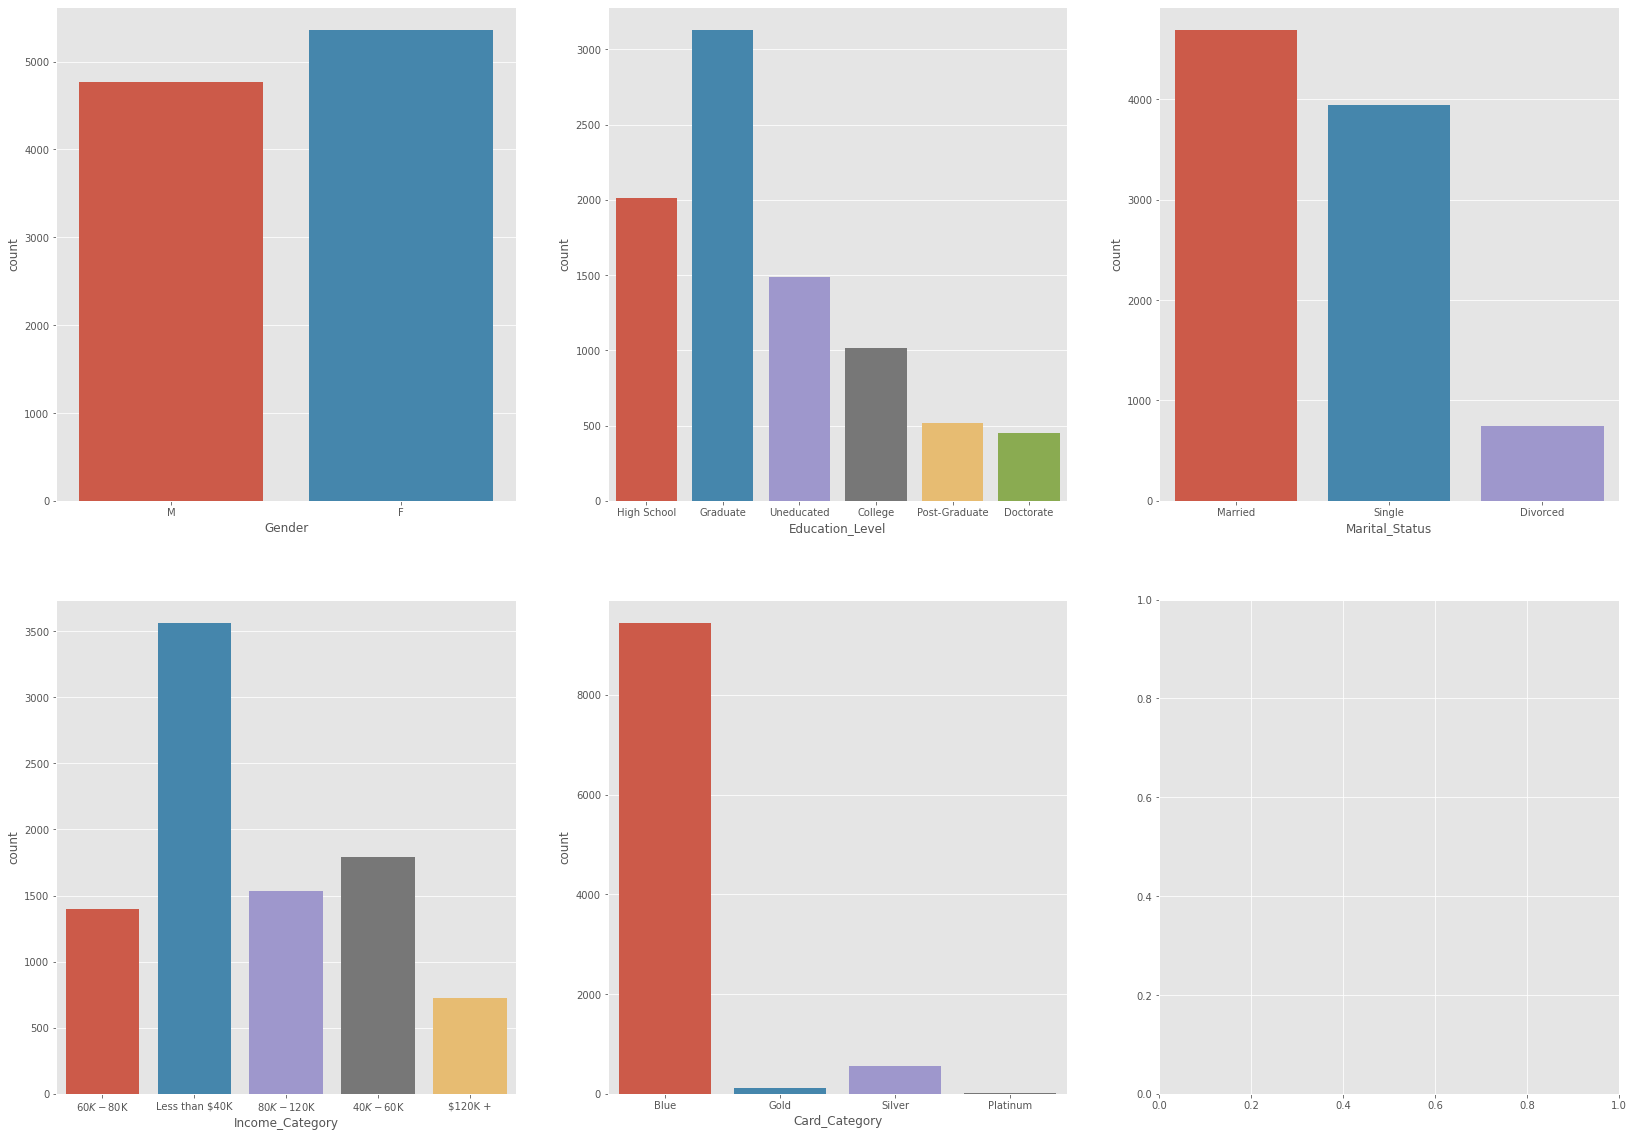

In [ ]:
plot_multiples_graficas(cat_data_sin_y,cat_columns, 3, 2, 'c', None, (28,20))

Encontramos que la característica *Gender* tiene una buena proporción de los datos entre ambos géneros. Para el caso de *Education_Level*, tenemos mayor cantidad en *Graduate* seguido por *High Schoo*l. En *Marital_Status* se tienen pocos registros con el estado *Divorced*. La característica *Income_Category*, la cual representa el ingreso anual del titular de la cuenta, tiene la mayor cantidad de datos en la categoría *Less than $40K*. Y por último para *Card_Category*, vemos que casi todos los clientes tienen la tarjeta *Blue*.

##Análisis con datos desbalanceados

###Dividir el conjunto de datos

En este caso, el 70% de los datos se utilizarán para entrenar el modelo. Procedemos a crear los datos de entrenamiento y de prueba:


In [ ]:
vDep = list(data_bank_processed.columns)

X = data_bank_processed[vDep]
y = data_bank["Attrition_Flag"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1), 
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
X[continuous_columns].head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45.0,3.0,39.0,5.0,1.0,3.0,12691.0,777.0,11914.0,1.335,1144.0,42.0,1.625,0.061
1,49.0,5.0,44.0,6.0,1.0,2.0,8256.0,864.0,7392.0,1.541,1291.0,33.0,3.714,0.105
2,51.0,3.0,36.0,4.0,1.0,0.0,3418.0,0.0,3418.0,2.594,1887.0,20.0,2.333,0.000
3,40.0,4.0,34.0,3.0,4.0,1.0,3313.0,2517.0,796.0,1.405,1171.0,20.0,2.333,0.760
4,40.0,3.0,21.0,5.0,1.0,0.0,4716.0,0.0,4716.0,2.175,816.0,28.0,2.500,0.000


Procedemos a escalar las variables continuas, dado que se evidencian diferencias considerables en los rangos de valores que registran en cada una de ellas.

In [ ]:
scaler = MinMaxScaler()
num_vars = continuous_columns
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.fit_transform(X_test[num_vars])

X_train[num_vars].head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
8606,0.468085,0.6,0.534884,0.2,0.333333,0.166667,0.031795,0.628526,0.026222,0.223727,0.398267,0.589147,0.178000,0.635636
4209,0.659574,0.4,0.720930,0.8,0.166667,0.333333,0.126179,0.748510,0.107930,0.226671,0.231414,0.565891,0.253143,0.336336
6776,0.553191,0.6,0.767442,1.0,0.833333,0.500000,0.041590,0.858959,0.018805,0.173094,0.205534,0.604651,0.238000,0.768769
6042,0.574468,0.2,0.744186,1.0,0.333333,0.500000,0.258866,0.000000,0.289688,0.198999,0.199721,0.496124,0.184000,0.000000
4638,0.638298,0.4,0.813953,0.6,0.500000,0.500000,0.091956,0.979340,0.058297,0.227259,0.152990,0.496124,0.194857,0.550551


###Creación del modelo

Para la creación de este modelo, vamos a tomar los parámetros:

*   *ovr − (one-versus-rest)*, dado que tenemos una clasificación binaria.

*   *liblinear*, puesto que nuestro datasets es pequeño.

*   *lbfgs (default)*, para validar otra opción de parámetro.

In [ ]:
modelLRovrLinea = LogisticRegression(multi_class = "ovr", solver='liblinear',  random_state=0)
modelLRovrlbfgs = LogisticRegression(multi_class = "ovr", solver='lbfgs',  random_state=0) 

modelLRovrLinea.fit(X_train, y_train)
modelLRovrlbfgs.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=0)

###Evaluación del modelo



####Accuracy

In [ ]:
y_predovrLinea = modelLRovrLinea.predict(X_test)
y_predovrlbfgs = modelLRovrlbfgs.predict(X_test)

print("===========Accuracy Logistic Regression ================")
print("ovr - Linear       :",metrics.accuracy_score(y_test, y_predovrLinea))
print("ovr - lbfgs        :",metrics.accuracy_score(y_test, y_predovrlbfgs))

===========Accuracy Logistic Regression ================
ovr - Linear       : 0.907864429088516
ovr - lbfgs        : 0.9081934846989141


Al evaluar los modelos con los parámetros se evidencia que la precisión es de 0.91 en ambos casos.

####Matriz de confusión

In [ ]:
y = data_bank["Attrition_Flag"]

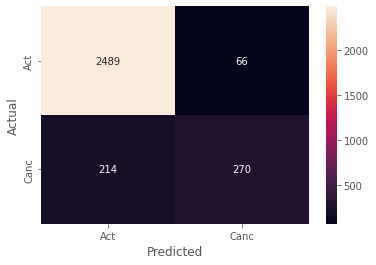

              precision    recall  f1-score   support

         Act       0.92      0.97      0.95      2555
        Canc       0.80      0.56      0.66       484

    accuracy                           0.91      3039
   macro avg       0.86      0.77      0.80      3039
weighted avg       0.90      0.91      0.90      3039



In [ ]:
conf_mat = confusion_matrix(y_test, y_predovrLinea)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_mat
            , annot=True
            , fmt='d'
            , xticklabels=data_bank["Attrition_Flag"].sort_values().unique()
            , yticklabels=data_bank["Attrition_Flag"].sort_values().unique()
           )
plt.ylabel('Real')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(y_test, y_predovrLinea, target_names=data_bank["Attrition_Flag"].sort_values().unique()))

En la matriz de confusión de los datos no balanceados, tal como se esperaba, se visualiza un muy buen comportamiento para las predicciones de los clientes activos con una sensibilidad del 97%, pero en el caso de los clientes cancelados, podemos ver que la especificidad es del 56%. 
En este modelo tenemos precisiones de 92% para los activos y 80% para los cancelados.
Basados en estas métricas, podemos ver que el modelo es muy bueno para predecir los clientes activos, pero no tanto los que van a cancelar.

####ROC

In [ ]:
e_dataframe = pd.DataFrame(y_test)
e_dataframe.replace('Act',1, inplace=True)
e_dataframe.replace('Canc', 0,inplace=True)
arr = e_dataframe.to_numpy()

AUC: 0.92


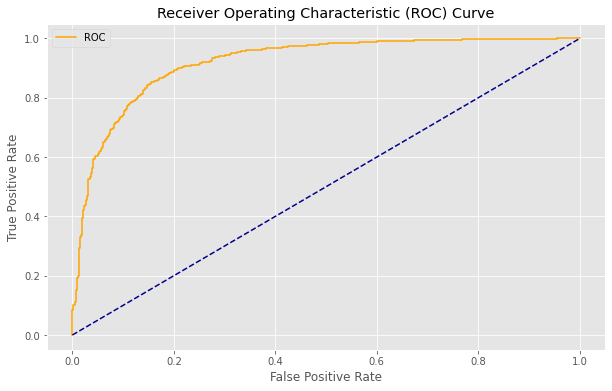

In [ ]:
fig = plt.figure(figsize=(10,6))

probs = modelLRovrLinea.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(arr, probs*(-1))

print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(arr, probs*(-1))
plot_roc_curve(fpr, tpr)

##Análisis con datos balanceados

###Dividir el conjunto de datos

In [ ]:
vDep = list(data_bank_processed.columns)

Xb = data_bank_processed[vDep]
yb = data_bank["Attrition_Flag"]

In [ ]:
Xb_train, Xb_test, yb_train, yb_test = train_test_split(
                                        Xb,
                                        yb.values.reshape(-1,1), 
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [ ]:
scaler = MinMaxScaler()
num_vars = continuous_columns
Xb_train[num_vars] = scaler.fit_transform(Xb_train[num_vars])
Xb_test[num_vars] = scaler.fit_transform(Xb_test[num_vars])

###Creación del modelo

Ahora procedemos a realizar el análisis con los datos balanceados:

In [ ]:
modelLRovrLinea_b = LogisticRegression(multi_class = "ovr", solver='liblinear', class_weight= "balanced", random_state=0)
modelLRovrlbfgs_b = LogisticRegression(multi_class = "ovr", solver='lbfgs', class_weight= "balanced",  random_state=0) 

modelLRovrLinea_b.fit(Xb_train, yb_train)
modelLRovrlbfgs_b.fit(Xb_train, yb_train)

LogisticRegression(class_weight='balanced', multi_class='ovr', random_state=0)

###Evaluación del modelo

####Accuracy

In [ ]:
y_predovrLinea_b = modelLRovrLinea_b.predict(Xb_test)
y_predovrlbfgs_b = modelLRovrlbfgs_b.predict(Xb_test)
print("===========Accuracy Logistic Regression ================")
print("ovr - Linear       :",metrics.accuracy_score(yb_test, y_predovrLinea_b))
print("ovr - lbfgs        :",metrics.accuracy_score(yb_test, y_predovrlbfgs_b))

===========Accuracy Logistic Regression ================
ovr - Linear       : 0.8512668641000329
ovr - lbfgs        : 0.8496215860480422


Se puede observar que con los datos balanceados perdemos precisión en el modelo, comparado con los datos no balanceados, esta se disminuye hasta el 0.8 

####Matriz de confusión

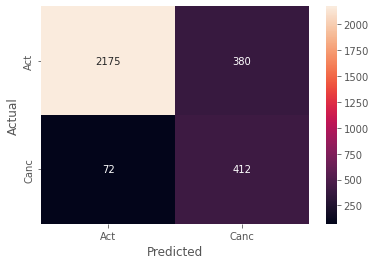

              precision    recall  f1-score   support

         Act       0.97      0.85      0.91      2555
        Canc       0.52      0.85      0.65       484

    accuracy                           0.85      3039
   macro avg       0.74      0.85      0.78      3039
weighted avg       0.90      0.85      0.86      3039



In [ ]:
conf_matb = confusion_matrix(yb_test, y_predovrLinea_b)

fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(conf_matb
            , annot=True
            , fmt='d'
            , xticklabels=data_bank["Attrition_Flag"].sort_values().unique()
            , yticklabels=data_bank["Attrition_Flag"].sort_values().unique()
           )
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print(metrics.classification_report(yb_test, y_predovrLinea_b, target_names=data_bank["Attrition_Flag"].sort_values().unique()))

Con los datos balanceados, vemos que la sensibilidad en los clientes activos pasa al 85%, pero en el caso de los clientes cancelados, podemos ver que la especificidad mejora al 85%, lo que nos permite detectar más clientes que van a cancelar. En este modelo tenemos precisiones de 97% para los activos y 52% para los cancelados. Basados en estas métricas, aunque la precisión en el caso de los cancelados baja, nos permite tener una predicción mayor de los clientes que van a cancelar para poder intervenirlos de manera proactiva, lo cual es el objetivo buscado por el negocio.

####ROC

AUC: 0.92


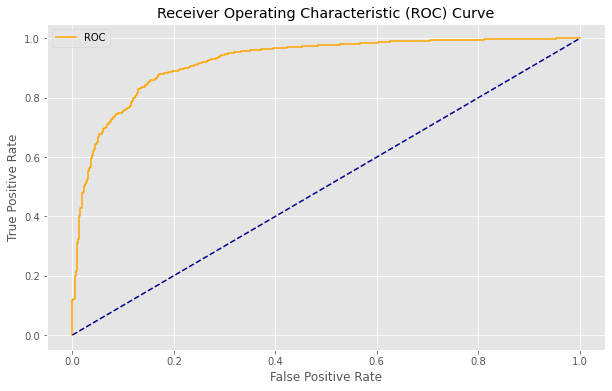

In [ ]:
fig = plt.figure(figsize=(10,6))

probs = modelLRovrLinea_b.predict_proba(Xb_test)
probs = probs[:, 1]
auc = roc_auc_score(arr, probs*(-1))

print('AUC: %.2f' % auc)
fpr, tpr, thresholds = roc_curve(arr, probs*(-1))
plot_roc_curve(fpr, tpr)

Se evidencia que el ROC es del 0.92, lo que nos indica que el test del modelo es bueno.

*************DEBEMOS REVISAR ESTOS ERRORES, ME SALE ERROR:

In [ ]:
# Error de test del modelo 
X = sm.add_constant(X) #Adding the constant
lm = sm.OLS(yb_train,Xb_train).fit() # fitting the model

predicciones = lm.predict(exog = Xb_test)

mse = mean_squared_error (y_true  = yb_test, y_pred  = predicciones, squared = True)
rmse = mean_squared_error (y_true  = yb_test, y_pred  = predicciones, squared = False)
MAE = mean_absolute_error (y_true  = yb_test, y_pred  = predicciones)
MedAE = median_absolute_error (y_true  = yb_test, y_pred  = predicciones)
r2 = r2_score (y_true  = yb_test, y_pred  = predicciones)

print(f"El error MSE   de test es: {mse}")
print(f"El error RMSE  de test es: {rmse}")
print(f"El error MAE   de test es: {MAE}")
print(f"El error MedAE de test es: {MedAE}")
print(f"El error R2    de test es: {r2}")

# 2 - Costo manejo desperdicios - Regresión Lineal

**Preparacion: Descargar Librerias y/o Datos**



En la siguiente celda, se descarga codigo relacionado con tratamiento estadistico de datos (deteccion de datos atipicos, escalamiento de datos con metodos de escalacion MIN-MAX, estandar y robusta, metodos de reduccion de dimensionalidad, metodos de correlacion entre variables, y metodos de regresion lineal). Se detalla a continuacion las clases y metodos usados:


1.   **Remove_Outliers_LOF**: La clase Remove_Outliers_LOF contiene el metodo process_outliers_non_labeled, el cual **retorna** un dataframe **DF** que contiene el numero y porcentaje de datos atipicos usando el metodo de LOF **sin** considerar la caracteristica **feature**, para cada metodo de escalacion predefinido (se consideran los datos sin escalar, y los escaladores previamente mencionados). **Tambien retorna un diccionario el cual contiene** en sus claves (cuyos valores son el metodo de escalamiento) **los datos filtrados sin datos atipicos.** 
Spearman_Correlation: La clase Spearman_Correlation contiene el metodo correlation_analysis, el cual permite analizar las correlaciones entre las diferentes variables presentes en el dataset pasado como argumento. El metodo imprime las correlaciones mas significativas con un p valor menor a 0.05 y valores de correlacion mayor a 0.8 o menor a -0.8.

2.    **get_scale_data_regression**: El metodo get_scale_data_regression **permite escalar** los datos del argumento de entrada **con escalador robusto, estandar, min-max e identidad** (este ultimo no tiene ningun efecto sobre los datos, el dato de salida es el mismo que el de entrada). 

3.    **ExperimentData**: La clase ExperimentData **permite generar un remuestreo de un conjunto de datos, y particionarlo en un conjunto de train y test con una particion fija de 0.75/0.25**

4.    **RawLinearRegression**: La clase RawLinearRegression corresponde a una **regresion lineal simple** basada en la presente la clase LinearRegression() de la libreria sklearn. Esta clase contiene un metodo apply que retorna un diccionario de metadatos con informacion del regresor entrenado, y las metricas de entrenamiento (explained_variance_score, r2, mean_absolute_error, mean_poisson_deviance, mean_gamma_deviance) aplicadas sobre un conjunto de test.

5.    **svmRegressor**: La clase svmRegressor corresponde a una **maquina de soporte vectorial de regresion** basada en la presente de la clase SVR de sklearn. Esta clase contiene un metodo apply que retorna un diccionario de metadatos con informacion del regresor entrenado, y las metricas de entrenamiento (explained_variance_score, mean_absolute_error, mean_poisson_deviance, mean_gamma_deviance) aplicadas sobre un conjunto de test.

6.    **rfRegressor**: La clase rfRegressor corresponde a un **random forest de regresion** basado en la presente en la clase RandomForestRegressor() de la libreria sklearn. Esta clase contiene un metodo apply que retorna un diccionario de metadatos con informacion del regresor entrenado, y las metricas de entrenamiento (explained_variance_score, mean_absolute_error, mean_poisson_deviance, mean_gamma_deviance) aplicadas sobre un conjunto de test.

7.    **dtRegressor**: La clase dtRegressor corresponde a un **arbol de decision de regresion** basado en la presente en la clase DecisionTreeRegressor() de sklearn. Esta clase contiene un metodo apply que retorna un diccionario de metadatos con informacion del regresor entrenado, y las metricas de entrenamiento (explained_variance_score, mean_absolute_error, mean_poisson_deviance, mean_gamma_deviance) aplicadas sobre un conjunto de test.

8.    **PCA_**: La clase PCA_ se basa en la clase presente en la libreria sklearn PCA. Esta clase contiene un metodo apply que permite detectar el numero de componentes optimos usando como criterio el 98% de varianza detectada. La clase contiene un atributo clave llamado metadata (diccionario) que contiene informacion de los datos transformados (clave trasnformed_data), el algoritmo pca entrenado (clave transformer), y un resumen que contiene informacion del error de transformacion (clave summary). 

9.    **ICA_**: La clase ICA_ se basa en la clase presente en la libreria sklearn FastICA. Esta clase contiene un metodo apply que permite detectar el numero de componentes optimos usando como criterio el error de transformacion. La clase contiene un atributo clave llamado metadata (diccionario) que contiene informacion de los datos transformados (clave trasnformed_data), el algoritmo pca entrenado (clave transformer), y un resumen que contiene informacion del error de transformacion (clave summary). 





In [1]:
!rm -rf *.csv
!rm -rf public
!rm -rf Taller4Estadistica
!git clone https://github.com/Alberto-San/public
!git clone https://github.com/Alberto-San/Taller4Estadistica

Cloning into 'public'...
remote: Enumerating objects: 74, done.
remote: Counting objects: 100% (74/74), done.
remote: Compressing objects: 100% (63/63), done.
remote: Total 74 (delta 31), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (74/74), done.
Cloning into 'Taller4Estadistica'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 33 (delta 10), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (33/33), done.


**DESCARGA DE LA BASE DE DATOS:** Municipal Waste Management Cost Prediction



**Descripcion Original de la base de datos**:

*...Municipal waste is defined as waste collected and treated by or for municipalities. It covers waste from households, including bulky waste, similar waste from commerce and trade, office buildings, institutions and small businesses, as well as yard and garden waste, street sweepings, the contents of litter containers, and market cleansing waste if managed as household waste. The definition excludes waste from municipal sewage networks and treatment, as well as waste from construction and demolition activities. This indicator is measured in thousand tonnes and in kilograms per capita...*

A continuacion se presenta el codigo para descargar la base de datos desde el cliente de kaggle.

In [2]:
from google.colab import drive
import os
drive.mount('/content/drive/')
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/' #+ input('Input the directory with your Kaggle json file: ')
!kaggle datasets download -d shashwatwork/municipal-waste-management-cost-prediction
!unzip \*.zip && rm *.zip

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
  0% 0.00/792k [00:00<?, ?B/s]
100% 792k/792k [00:00<00:00, 21.5MB/s]
Archive:  municipal-waste-management-cost-prediction.zip
  inflating: public_data_waste_fee.csv  


**Librerias Usadas**

In [3]:
import pandas as pd
from google.colab import drive
import os
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt 
import seaborn as sns
from public.spearmanCorrelation import *
from public.pca import PCA_
from public.ica import ICA_		  
from public.removeOutliersLOF import Remove_Outliers_LOF
from public.removeOutliersLOF import LocalOutlierFactor
from Taller4Estadistica.Script import RawLinearRegression, svmRegressor, rfRegressor, dtRegressor, ExperimentData
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

**Leyendo Datos de Entrada**
A continuacion se lee los datos de entrada usando la libreria pandas, y se analiza los tipos de datos de cada columna. La caracteristica de regresion corresponde a la variable finance

In [4]:
df = pd.read_csv('public_data_waste_fee.csv')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4341 entries, 0 to 4340
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      4341 non-null   object 
 1   province    4341 non-null   object 
 2   name        4335 non-null   object 
 3   tc          4341 non-null   float64
 4   cres        4289 non-null   float64
 5   csor        4274 non-null   float64
 6   istat       4341 non-null   int64  
 7   area        4335 non-null   float64
 8   pop         4341 non-null   int64  
 9   alt         4335 non-null   float64
 10  isle        4335 non-null   float64
 11  sea         4335 non-null   float64
 12  pden        4335 non-null   float64
 13  wden        4335 non-null   float64
 14  urb         4335 non-null   float64
 15  fee         4341 non-null   object 
 16  d_fee       4341 non-null   int64  
 17  sample      4341 non-null   int64  
 18  organic     3829 non-null   float64
 19  paper       4316 non-null  

,region,province,name,tc,cres,csor,istat,area,pop,alt,...,msw,sor,geo,roads,s_wteregio,s_landfill,gdp,proads,wage,finance
0,Emilia_Romagna,Ferrara,Comacchio,502.250000,129.270004,66.419998,38006,283.750000,22648,1.0,...,33956781,60.07,3.0,285.0,33.105049,15.233530,7.269942,4.354818,9.438692,7.488041
1,Emilia_Romagna,Ferrara,Lagosanto,228.050003,49.520000,44.139999,38011,34.439999,4952,1.0,...,2411867,75.93,3.0,11.0,33.105049,15.233530,7.109984,6.082588,9.510139,7.323284
2,Emilia_Romagna,Ferrara,Goro,268.010010,50.610001,44.599998,38025,26.620001,3895,1.0,...,2159322,78.49,3.0,49.0,33.105049,15.233530,7.267856,4.335555,8.891356,7.485891
3,Emilia_Romagna,Ferrara,Mesola,199.089996,41.110001,40.439999,38014,84.300003,7140,1.0,...,3651915,78.89,3.0,165.0,33.105049,15.233530,7.085936,3.710479,9.433685,7.298514
4,Puglia,Barletta-Andria-Trani,Margherita di Savoia,233.639999,58.270000,25.950001,110005,35.700001,12193,1.0,...,7195880,42.06,1.0,60.0,4.046452,45.411903,7.247444,5.274037,9.125561,7.464867


Se observa que los tipos de datos reportados como **object**, corresponden a columnas que contienen valores descriptivos. 

El segundo analisis que se procede a realizar, es analizar el numero de datos atipicos por columna

**Deteccion de datos nulos e imputacion**


    Cantidad de datos faltantes por columna 


    


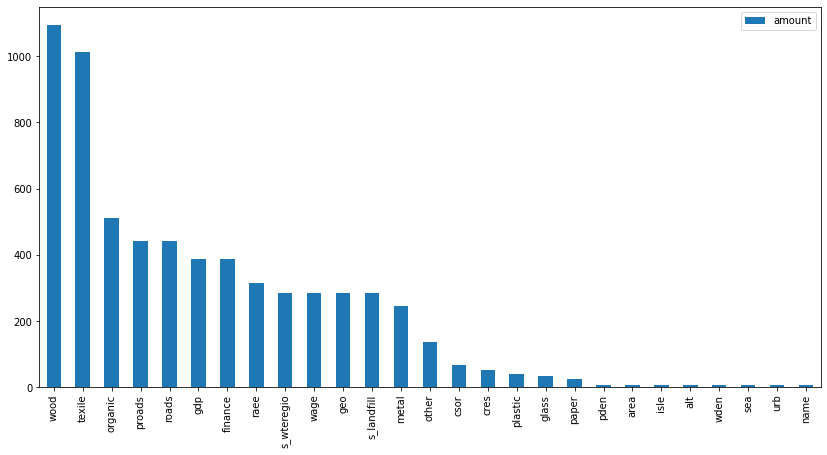

In [5]:
def print_null_data(df):
  serie = df.isna().sum()
  df1 = pd.DataFrame(serie, columns=["amount"])
  df2 = df1[df1["amount"] > 0].sort_values("amount", ascending=False)
  return df2

break_lines = 2 * "\n"
print(
    '''
    Cantidad de datos faltantes por columna {}
    '''.format(break_lines)
)
print_null_data(df).plot.bar(figsize=(14, 7))

Se observa que existe un gran numero de datos atipicos en las columnas wood y textile.
Se decide antes de hacer un proceso de imputacion, transformar las columnas cualitativas en cuantitativas a traves de un algoritmo de codificacion de etiquetas

In [6]:
def getIndexesOfNaN(data_transformed):
  indexes = {}
  for column in data_transformed.columns:
    inds = pd.isnull(data_transformed)
    indexes[column] = inds.index[inds[column]==True]

  return indexes

def getEncodedWithNaNData(data_transformed, categorical_columns, indexes):
  data_categorical_transformed = data_transformed[categorical_columns]
  LE = defaultdict(LabelEncoder)
  data_encoded = data_categorical_transformed.apply(lambda x: LE[x.name].fit_transform(x))
  data_processed = data_encoded.copy()
  columns = data_transformed.columns

  for column in columns:
    if len(indexes[column]) > 0:
      data_processed.loc[indexes[column], column] = np.NaN

  return data_processed


def convert_categorical_to_number(df, columns):
  df_categorical = df[columns]
  indexes_nan = getIndexesOfNaN(df_categorical)
  data_processed = getEncodedWithNaNData(df_categorical, columns, indexes_nan)
  df_final = df.copy()
  for column in columns:
    df_final[column] = data_processed[column]
  return df_final

In [7]:
df_transformed = df.drop("name", axis=1)
columns = ["region", "province", "fee", "gdp"]
df_continuous = convert_categorical_to_number(df_transformed, columns)
df_continuous.tail(5)

,region,province,tc,cres,csor,istat,area,pop,alt,isle,...,msw,sor,geo,roads,s_wteregio,s_landfill,gdp,proads,wage,finance
4336,18,100,122.500000,44.320000,43.590000,24125,NaN,5031,NaN,NaN,...,2113374,71.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4337,8,95,126.220001,51.250000,22.620001,12143,NaN,2623,NaN,NaN,...,1240725,79.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4338,18,9,94.190002,17.080000,47.700001,25074,NaN,13515,NaN,NaN,...,5554469,88.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4339,18,100,169.559998,70.230003,75.250000,24127,NaN,4683,NaN,NaN,...,2172620,67.73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4340,18,100,75.339996,23.549999,32.580002,24126,NaN,5986,NaN,NaN,...,2102724,81.89,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Se observa en la tabla anterior, como los datos cualitativos ahora contienen valores numericos. Se define a continuacion una funcion con el objetivo de realizar una imputacion por la mediana

In [8]:

def imputation_data(data_processed):
  columns = data_processed.columns
  for column in columns:
    median = data_processed[column].median()
    data_processed[column] = data_processed[column].fillna(median)

  return data_processed

In [9]:
data_imputed = imputation_data(df_continuous)
data_imputed.tail(5)

,region,province,tc,cres,csor,istat,area,pop,alt,isle,...,msw,sor,geo,roads,s_wteregio,s_landfill,gdp,proads,wage,finance
4336,18,100,122.500000,44.320000,43.590000,24125,22.73,5031,240.0,0.0,...,2113374,71.70,3.0,51.0,24.467649,11.296785,1975.0,4.35621,9.522799,7.34193
4337,8,95,126.220001,51.250000,22.620001,12143,22.73,2623,240.0,0.0,...,1240725,79.55,3.0,51.0,24.467649,11.296785,1975.0,4.35621,9.522799,7.34193
4338,18,9,94.190002,17.080000,47.700001,25074,22.73,13515,240.0,0.0,...,5554469,88.30,3.0,51.0,24.467649,11.296785,1975.0,4.35621,9.522799,7.34193
4339,18,100,169.559998,70.230003,75.250000,24127,22.73,4683,240.0,0.0,...,2172620,67.73,3.0,51.0,24.467649,11.296785,1975.0,4.35621,9.522799,7.34193
4340,18,100,75.339996,23.549999,32.580002,24126,22.73,5986,240.0,0.0,...,2102724,81.89,3.0,51.0,24.467649,11.296785,1975.0,4.35621,9.522799,7.34193


Se observa en la tabla anterior como los datos que antes tenian NaN ahora se encuentran imputados

**Deteccion de datos Atipicos**

Para la deteccion de datos atipicos se usa el algoritmo Local Outlier Factor. Sklearn provee una descripcion detallada sobre como es su operacion (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html).

*The anomaly score of each sample is called the Local Outlier Factor. It measures the local deviation of the density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood. More precisely, locality is given by k-nearest neighbors, whose distance is used to estimate the local density. By comparing the local density of a sample to the local densities of its neighbors, one can identify samples that have a substantially lower density than their neighbors. These are considered outliers.*

Como se puede deducir, en este algoritmo se mide la densidad de una muestra con respecto a la de sus vecinos, y de esta manera se van detectando los datos atipicos

In [10]:
output_feature = "finance"
summary_df, data_dic_collection = Remove_Outliers_LOF().process_outliers_non_labeled(data_imputed, regression=True, feature=output_feature)
print("Las claves del diccionario data_dic_collection son ({})".format(data_dic_collection.keys()))

Las claves del diccionario data_dic_collection son (dict_keys(['', 'robust', 'StandardScaler', 'mixMax']))


In [11]:
print("El contenido de una de las claves es")
data_dic_collection["robust"]

El contenido de una de las claves es


[      region  province          tc        cres       csor   istat        area  \
 0          4        30  502.250000  129.270004  66.419998   38006  283.750000   
 1          4        30  228.050003   49.520000  44.139999   38011   34.439999   
 2          4        30  268.010010   50.610001  44.599998   38025   26.620001   
 3          4        30  199.089996   41.110001  40.439999   38014   84.300003   
 4         11         8  233.639999   58.270000  25.950001  110005   35.700001   
 ...      ...       ...         ...         ...        ...     ...         ...   
 4119       8        52  120.300003   26.510000  72.089996   15251   22.730000   
 4120      18       100  122.500000   44.320000  43.590000   24125   22.730000   
 4121       8        95  126.220001   51.250000  22.620001   12143   22.730000   
 4122      18       100  169.559998   70.230003  75.250000   24127   22.730000   
 4123      18       100   75.339996   23.549999  32.580002   24126   22.730000   
 
         pop  

In [12]:
summary_df[["scaler", "number_rejected", "percentaje_rejected"]]

,scaler,number_rejected,percentaje_rejected
0,,217,0.049988
0,robust,217,0.049988
0,StandardScaler,217,0.049988
0,mixMax,217,0.049988


Se observa, como para diferentes metodos de escalacion de la base de datos (sin considerar la caracteristica finance), que el numero de datos atipicos resulta ser el mismo. Ademas de esto **data_dic_collection** sostiene los datos originales filtrados sin datos atipicos de cada uno de los metodos de escalamiento. Debido a que no existe una diferencia significa, en los analisis subsiguientes se consideraran cada uno de los metodos de escalamiento mencionados

**Correlacion Entre Variables**

Para la correlacion entre variables se usa el metodo de correlacion de Spearman. Una descripcion de scipy permite observar como funciona este algoritmo (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.spearmanr.html).

*The Spearman rank-order correlation coefficient is a nonparametric measure of the monotonicity of the relationship between two datasets. Unlike the Pearson correlation, the Spearman correlation does not assume that both datasets are normally distributed. Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact monotonic relationship. Positive correlations imply that as x increases, so does y. Negative correlations imply that as x increases, y decreases.*

Como se observa, la correlacion de Spearman no asume que los datos siguen una distribucion normal, lo cual es ventajoso a la hora de comparar diferentes variables entre si

In [13]:
scaler = ""
data_corr = data_dic_collection[scaler][0].drop(output_feature, axis=1)
Spearman_Correlation().correlation_analysis(data_corr)

(pop, msw_so) (pvalue=0.000, corr=0.954)
(pop, msw_un) (pvalue=0.000, corr=0.886)
(pop, msw) (pvalue=0.000, corr=0.970)
(pden, wden) (pvalue=0.000, corr=0.973)
(fee, d_fee) (pvalue=0.000, corr=-1.000)
(msw_so, msw_un) (pvalue=0.000, corr=0.830)
(msw_so, msw) (pvalue=0.000, corr=0.978)
(msw_un, msw) (pvalue=0.000, corr=0.920)




Podemos observar las correlaciones mas relevantes del conjunto de datos utilizando el metodo de spearman. Se decide filtrar las variables:

    msw_so: debido a que se puede ver representada por msw
    msw_un: debido a que se puede ver representada por msw
    fee: debido a que se ve representada por d_fee


In [14]:
# Se filtra la variable gdp ya que se hizo un analisis previo y tiene una correlacion alta con respecto a la variable de salida, y deseamos en este ejercicio explorar
# regresiones lineales que no asuman que una de las variables de entrada describe completamente la de salida
# De igual manera para el proceso de regresion lineal se descartan las variables cualitativas, ya que su representacion numerica no tienen significado en la regresion
categorical_features = ["region", "province", "fee", "name"]
filter_features = ["msw_so", "msw_un", "fee", "gdp"] + categorical_features
columns = df.columns
columns_filtered = [column for column in columns if column not in filter_features]

Se filtran las columnas anterior del conjunto de datos, usando como referencia el dataset sin valores atipico **data_dic_collection** el cual contiene los diferentes metodos de escalamiento. **get_scale_data_regression** permite aplicadar el metodo de escalamiento a los datos de data_dic_collection

In [15]:
data_dic = {}
data_dic[""] = get_scale_data_regression(data_imputed, data_dic_collection, scaler="", feature="finance")[columns_filtered]
data_dic["robust"] = get_scale_data_regression(data_imputed, data_dic_collection, scaler="robust", feature="finance")[columns_filtered]
data_dic["StandardScaler"] = get_scale_data_regression(data_imputed, data_dic_collection, scaler="StandardScaler", feature="finance")[columns_filtered]
data_dic["mixMax"] = get_scale_data_regression(data_imputed, data_dic_collection, scaler="mixMax", feature="finance")[columns_filtered]

Se definen a continuacion una funcion para realizar los experimentos con los siguientes parametros:



1.   Metodos de escalamiento: Identidad, min-max, estandar, robusto
2.   Metodos de reduccion de dimensionalidad: pca, ica
3.   Metodos de regresion lineal: regresion lineal simple, regresion lineal con maquina de soporte vectorial, regresion lineal con random forest y regresion lineal con arbol de decision



In [16]:
def save_data_to_csv(flagSummary, metadata_, name):
  if flagSummary:
    flagSummary = False
    summary = metadata_["metric_information"]
    summary.to_csv(name, index=False)
  else:
    summary = metadata_["metric_information"]
    summary.to_csv(name, index=False, mode='a', header=False)
  return flagSummary

def experiments(data_dic_pre, output_feature, name, sample=1):

  metadata = {}
  sample = 1
  scalers = list(data_dic_pre.keys())
  summary = None # Inicializador de Variable
  flagSummary = True # Bandera que permite crear el archivo name en la primera iteracion, y en las siguientes generar append de la informacion de los experimentos
  algoritms = {
    "pca": PCA_(),
    "ica": ICA_()
  }
  linear_regressors = {
    "regresion lineal": RawLinearRegression(),
    "regresion svm rbf": svmRegressor(kernel="rbf"),
    "regresion random forest": rfRegressor(),
    "regresion decision tree": dtRegressor()
  }
  
  for scaler in scalers:
    for method in algoritms.keys():
      raw_data = data_dic_pre[scaler]
      for regressor in linear_regressors.keys():
        description = "scaler: {} - dim red: {} - regressor: {}".format(scaler, method, regressor)
        print(description)
        method_ = algoritms[method]
        regressor_ =  linear_regressors[regressor]
        method_.apply(raw_data.drop(output_feature, axis=1), scaler)
        X = method_.metadata["transformed_data"]
        Y = raw_data[output_feature]
        datos_reduce = pd.concat([X, Y], axis=1)
        train_test_set = ExperimentData().apply(datos_reduce, output_feature, sample)
        metadata_ = regressor_.apply(train_test_set, description=description)
        trained_regressor = metadata_["regressor"]
        metadata[description] = [trained_regressor, train_test_set]
        flagSummary = save_data_to_csv(flagSummary, metadata_, name)

  return summary, metadata

In [17]:
summary, metadata = experiments(data_dic, output_feature, name="results.csv", sample=1)

scaler:  - dim red: pca - regressor: regresion lineal
scaler:  - dim red: pca - regressor: regresion svm rbf
scaler:  - dim red: pca - regressor: regresion random forest
scaler:  - dim red: pca - regressor: regresion decision tree
scaler:  - dim red: ica - regressor: regresion lineal
scaler:  - dim red: ica - regressor: regresion svm rbf
scaler:  - dim red: ica - regressor: regresion random forest
scaler:  - dim red: ica - regressor: regresion decision tree
scaler: robust - dim red: pca - regressor: regresion lineal
scaler: robust - dim red: pca - regressor: regresion svm rbf
scaler: robust - dim red: pca - regressor: regresion random forest
scaler: robust - dim red: pca - regressor: regresion decision tree
scaler: robust - dim red: ica - regressor: regresion lineal
scaler: robust - dim red: ica - regressor: regresion svm rbf
scaler: robust - dim red: ica - regressor: regresion random forest
scaler: robust - dim red: ica - regressor: regresion decision tree
scaler: StandardScaler - dim

In [18]:
summary_experiment = pd.read_csv("results.csv")
summary_experiment.head(5)

,description,mse,r2,explained_variance_score_,mean_absolute_error_,mean_poisson_deviance_,mean_gamma_deviance_
0,scaler: - dim red: pca - regressor: regresion...,-0.285016,0.047074,0.051086,0.416861,0.037428,0.004944
1,scaler: - dim red: pca - regressor: regresion...,-0.258900,NaN,0.178406,0.375469,0.033232,0.004368
2,scaler: - dim red: pca - regressor: regresion...,-0.239871,NaN,0.136659,0.394682,0.033805,0.004435
3,scaler: - dim red: pca - regressor: regresion...,-0.374276,NaN,-0.539956,0.520723,0.059795,0.007793
4,scaler: - dim red: ica - regressor: regresion...,-0.277871,0.070952,0.077957,0.410124,0.036326,0.004793


Se procesa la informacion para encontrar cual es el mejor metodo de escalamiento y mejor metodo de reduccion de dimensionalidad que permite obtener el menor mae para cada regresor usado

In [19]:
summary_experiment["regresor"] = summary_experiment["description"].apply(lambda x: x.split(" - ")[2])
summary_experiment["set"] = summary_experiment["description"].apply(lambda x: x.split(" - ")[0] + " - " + x.split(" - ")[1])

best_regressors = pd.DataFrame(summary_experiment.groupby(by="regresor")["mean_absolute_error_"].min()).reset_index()
best_set_up = pd.merge(summary_experiment,best_regressors,on=["regresor", "mean_absolute_error_"])
best_description = best_set_up.sort_values(by="mean_absolute_error_")["description"].values.tolist()[0]
best_set_up[["regresor", "set", "mean_absolute_error_"]].sort_values(by="mean_absolute_error_")

,regresor,set,mean_absolute_error_
0,regressor: regresion svm rbf,scaler: mixMax - dim red: pca,0.253873
1,regressor: regresion random forest,scaler: mixMax - dim red: pca,0.266220
3,regressor: regresion lineal,scaler: mixMax - dim red: ica,0.297199
2,regressor: regresion decision tree,scaler: mixMax - dim red: pca,0.369644


Se observa, que en general el mejor metodo de escalamiento que permite conseguir el menor mae para cada uno de los regresores es minMAx, y el mejor metodo de reduccion de dimensionalidad pca. Se observa que el valor mas bajo se obtiene para regresion con maquina de soporte vectorial y kernel rbf

**Exploracion de Hiperparametros y Finne Tuning del Modelo Escogido**

Dado que el modelo cuenta con parametros genericos, vamos a explorar diferentes valores de gamma y de C que permitan obtener una mejora en el mae para la maquina de soporte vectorial con kernel RBF

In [21]:
from sklearn.svm import SVR

[LR, metadataExperiment] = metadata[best_description]
train_data = metadataExperiment["input_features_train"]
train_output = metadataExperiment["output_feature_train"]
test_data = metadataExperiment["input_features_test"]
test_output = metadataExperiment["output_feature_test"]


C_range = list(np.logspace(-2, 1, 8))
gamma_range = list(np.logspace(-4, 1, 8))
metric_information = []

for c in C_range:
  for gamma in gamma_range:
    print("Start")
    print("(C={}, Gamma={})".format(c, gamma))
    local_regressor = SVR(kernel = "rbf", gamma=gamma, C=c, max_iter=100000)
    local_regressor.fit(train_data, train_output)
    metric_information.append(svmRegressor().get_model_metadata(local_regressor, test_data, test_output, "(C={}, Gamma={})".format(c, gamma)))
    print("Done")


metrics = pd.concat(metric_information)[["description", "mean_absolute_error_"]].sort_values(by="mean_absolute_error_")
metrics

Start
(C=0.01, Gamma=0.0001)
Done
Start
(C=0.01, Gamma=0.0005179474679231213)
Done
Start
(C=0.01, Gamma=0.002682695795279727)
Done
Start
(C=0.01, Gamma=0.013894954943731374)
Done
Start
(C=0.01, Gamma=0.07196856730011521)
Done
Start
(C=0.01, Gamma=0.3727593720314942)
Done
Start
(C=0.01, Gamma=1.9306977288832496)
Done
Start
(C=0.01, Gamma=10.0)
Done
Start
(C=0.02682695795279726, Gamma=0.0001)
Done
Start
(C=0.02682695795279726, Gamma=0.0005179474679231213)
Done
Start
(C=0.02682695795279726, Gamma=0.002682695795279727)
Done
Start
(C=0.02682695795279726, Gamma=0.013894954943731374)
Done
Start
(C=0.02682695795279726, Gamma=0.07196856730011521)
Done
Start
(C=0.02682695795279726, Gamma=0.3727593720314942)
Done
Start
(C=0.02682695795279726, Gamma=1.9306977288832496)
Done
Start
(C=0.02682695795279726, Gamma=10.0)
Done
Start
(C=0.07196856730011521, Gamma=0.0001)
Done
Start
(C=0.07196856730011521, Gamma=0.0005179474679231213)
Done
Start
(C=0.07196856730011521, Gamma=0.002682695795279727)
Done
Star

,description,mean_absolute_error_
0,"(C=10.0, Gamma=0.3727593720314942)",0.253572
0,"(C=1.3894954943731375, Gamma=1.9306977288832496)",0.254109
0,"(C=3.727593720314938, Gamma=0.3727593720314942)",0.254126
0,"(C=0.517947467923121, Gamma=1.9306977288832496)",0.254426
0,"(C=3.727593720314938, Gamma=1.9306977288832496)",0.256488
...,...,...
0,"(C=0.02682695795279726, Gamma=0.00051794746792...",0.397374
0,"(C=0.07196856730011521, Gamma=0.0001)",0.399470
0,"(C=0.01, Gamma=0.0005179474679231213)",0.400173
0,"(C=0.02682695795279726, Gamma=0.0001)",0.400990


Se observa en el dataframe anterior, como se obtuvo una mejora poco significa de 0.2539 a 0.2536 usando (C=10.0, Gamma=0.3727593720314942) en contraste con (C=1, gamma=0.8868), este ultimo siendo los hiperparametros del modelo original

**Visualizacion Cualitativa de la Regresion Lineal por SVM**

A continuacion se visualizan para cada una de las variables reducidas en su dimensionalidad del dataset escogido (escalador min-max, red dim por pca), con la regresion por maquina de soporte vectorial y kernel RBF

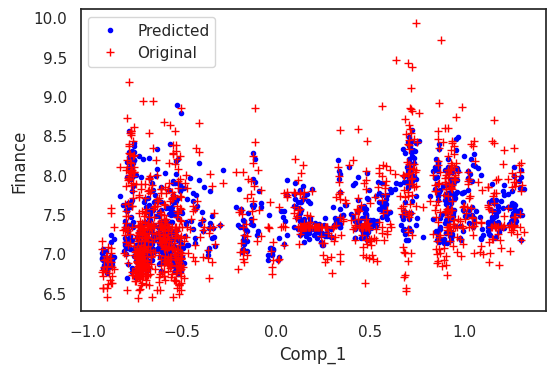

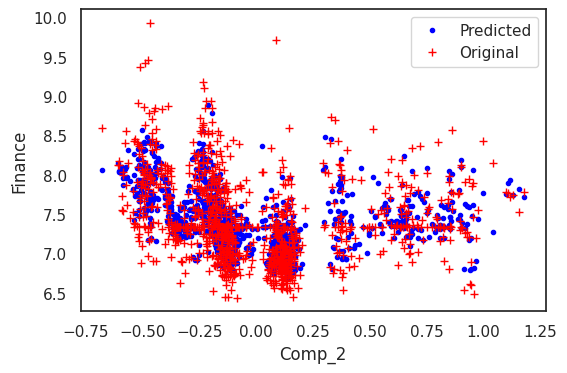

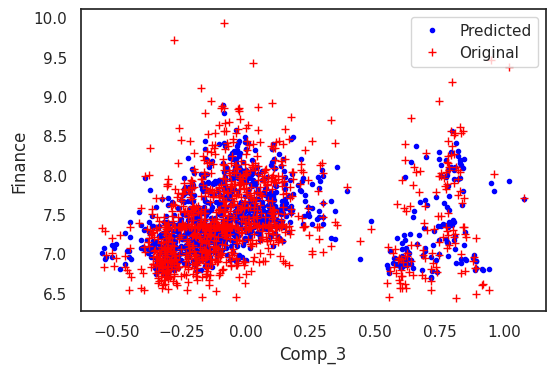

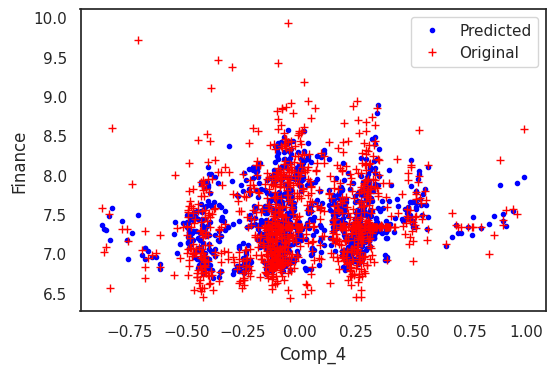

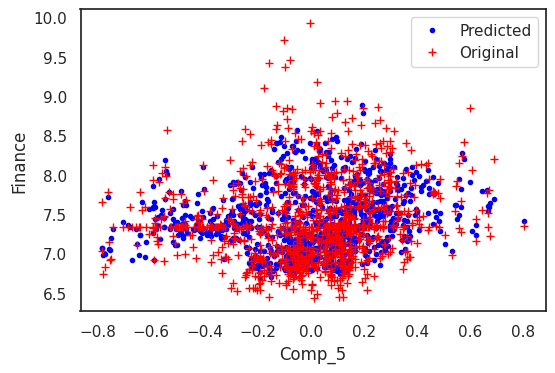

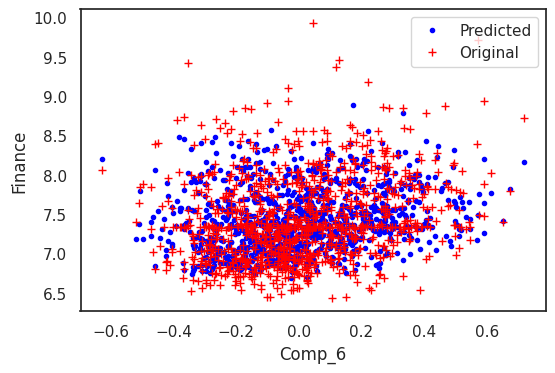

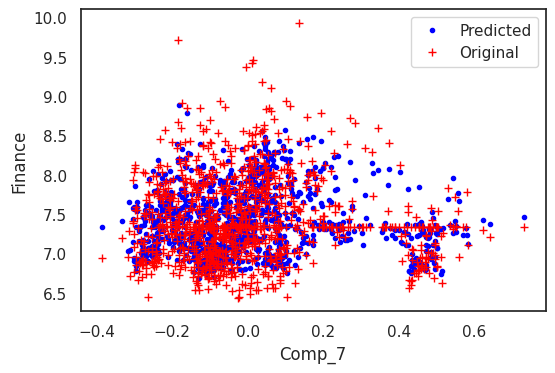

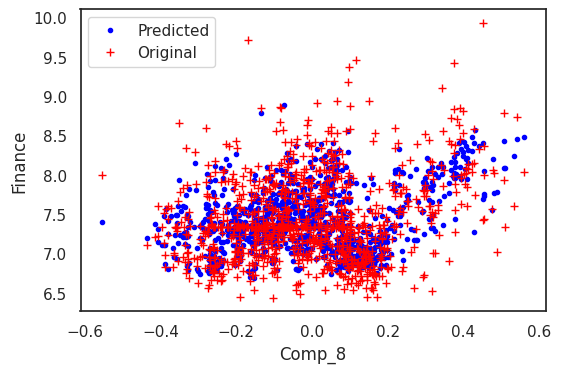

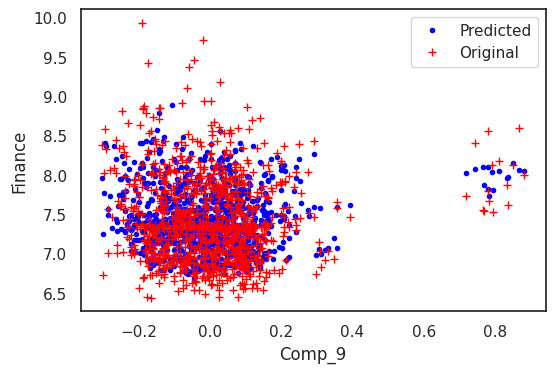

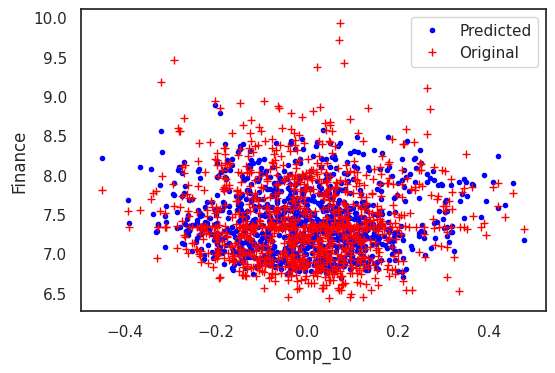

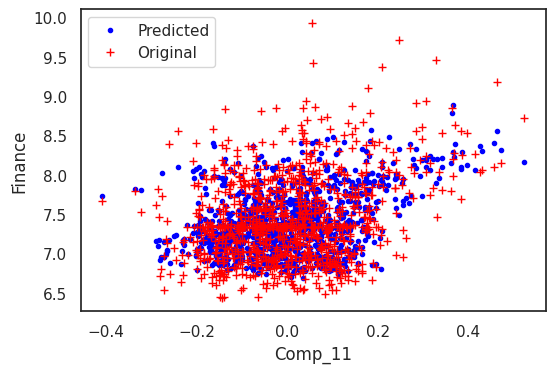

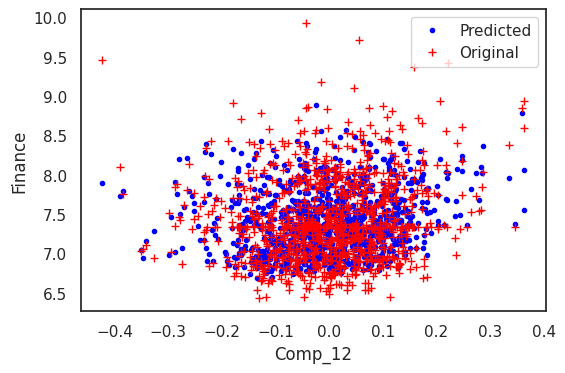

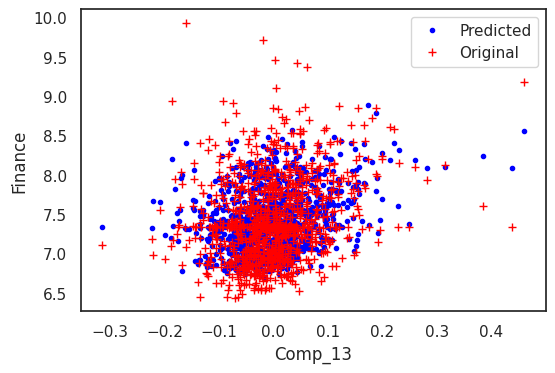

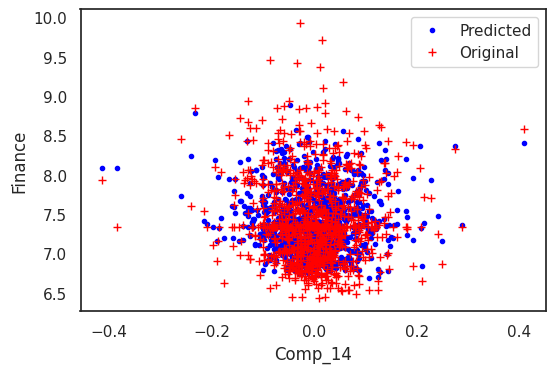

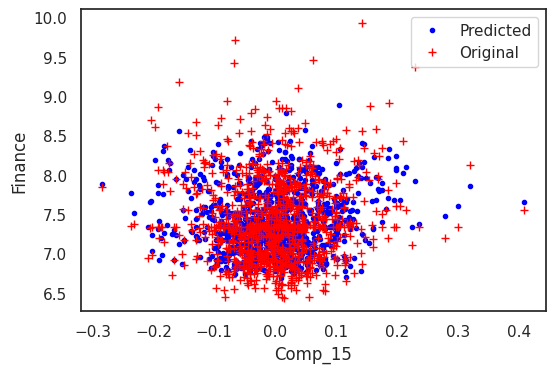

In [39]:
[LR, metadataExperiment] = metadata[best_description]
test_data = metadataExperiment["input_features_test"]
test_output = metadataExperiment["output_feature_test"]
predicted_output = LR.predict(test_data)
columns = test_data.columns 

for column in columns:
  sns.set_theme(style="white")
  plt.figure(dpi = (100))
  plt.plot(test_data[column], predicted_output, ".", color="blue", label='Predicted')
  plt.plot(test_data[column], test_output, "+", color="red", lw=2, label='Original')
  plt.xlabel(column)
  plt.ylabel("Finance")
  plt.legend()
  plt.show()

Se observa cualitativamente que los datos predecidos y originales son muy similares entre si en zonas donde existe mayor concentracion de datos, lo cual tiene sentido, ya que el modelo intenta minimizar el error, el cual a su vez se minimiza si se ajusta mas en las zonas de mayor densidad de datos